##### *I have learned the Model from, who topped the Hackathon in AV-Lessons Learnt*
 - *Feature Generation is important*
 - *Data Study*

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
from xgboost import XGBRegressor
from xgboost import plot_importance
import time

In [2]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [3]:
train=pd.read_csv('train_aWnotuB.csv',parse_dates=['DateTime'])
test=pd.read_csv('test_BdBKkAj_L87Nc3S.csv',parse_dates=['DateTime'])
sub=pd.read_csv('sample_submission_KVKNmI7.csv')

In [4]:
train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
train.dtypes

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
dtype: object

In [6]:
def create_date_featues(df):

    df['Year'] = pd.to_datetime(df['DateTime']).dt.year

    df['Month'] = pd.to_datetime(df['DateTime']).dt.month

    df['Day'] = pd.to_datetime(df['DateTime']).dt.day

    df['Dayofweek'] = pd.to_datetime(df['DateTime']).dt.dayofweek

    df['DayOfyear'] = pd.to_datetime(df['DateTime']).dt.dayofyear

    df['Week'] = pd.to_datetime(df['DateTime']).dt.week

    df['Quarter'] = pd.to_datetime(df['DateTime']).dt.quarter 

    df['Is_month_start'] = pd.to_datetime(df['DateTime']).dt.is_month_start

    df['Is_month_end'] = pd.to_datetime(df['DateTime']).dt.is_month_end

    df['Is_quarter_start'] = pd.to_datetime(df['DateTime']).dt.is_quarter_start

    df['Is_quarter_end'] = pd.to_datetime(df['DateTime']).dt.is_quarter_end

    df['Is_year_start'] = pd.to_datetime(df['DateTime']).dt.is_year_start

    df['Is_year_end'] = pd.to_datetime(df['DateTime']).dt.is_year_end

    df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2)

    df['Is_weekend'] = np.where(df['Dayofweek'].isin([5,6]),1,0)

    df['Is_weekday'] = np.where(df['Dayofweek'].isin([0,1,2,3,4]),1,0)
    
    df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour

    return df

In [7]:
create_date_featues(train)
create_date_featues(test)
test.head(2)

,DateTime,Junction,ID,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekend,Is_weekday,Hour
0,2017-07-01 00:00:00,1,20170701001,2017,7,1,5,182,26,3,True,False,True,False,False,False,2,1,0,0
1,2017-07-01 01:00:00,1,20170701011,2017,7,1,5,182,26,3,True,False,True,False,False,False,2,1,0,1


In [8]:
train.groupby(['Year','Month'])['Vehicles'].mean()

Year  Month
2015  11       11.911574
      12       11.121416
2016  1        13.799731
      2        17.524425
      3        17.512993
      4        19.358333
      5        19.552419
      6        18.889815
      7        21.837814
      8        21.936380
      9        25.644907
      10       26.551075
      11       27.156944
      12       26.806452
2017  1        24.173051
      2        27.186384
      3        27.243616
      4        28.276389
      5        28.444220
      6        31.388889
Name: Vehicles, dtype: float64

In [9]:
test.groupby(['Year','Month']).mean()

Junction            ID   Day  Dayofweek  DayOfyear       Week  \
Year Month                                                                  
2017 7           2.5  2.017072e+10  16.0   3.064516      197.0  28.419355   
     8           2.5  2.017082e+10  16.0   2.903226      228.0  32.870968   
     9           2.5  2.017092e+10  15.5   3.100000      258.5  37.200000   
     10          2.5  2.017102e+10  16.0   2.935484      289.0  41.580645   

            Quarter  Is_month_start  Is_month_end  Is_quarter_start  \
Year Month                                                            
2017 7          3.0        0.032258      0.032258          0.032258   
     8          3.0        0.032258      0.032258          0.000000   
     9          3.0        0.033333      0.033333          0.000000   
     10         4.0        0.032258      0.032258          0.032258   

            Is_quarter_end  Is_year_start  Is_year_end  Semester  Is_weekend  \
Year Month                                                                     
2017 7            0.000000            0.0          0.0       2.0    0.322581   
     8            0.000000            0.0          0.0       2.0    0.258065   
     9            0.033333            0.0          0.0       2.0    0.300000   
     10           0.000000            0.0          0.0       2.0    0.290323   

            Is_weekday  Hour  
Year Month                    
2017 7        0.677419  11.5  
     8        0.741935  11.5  
     9        0.700000  11.5  
     10       0.709677  11.5

###### Ignoring 2015 Data because we are predicting for months 7,8,9,10 and 2015 data consists of month 11,12 and also Vehicle trend was low during 2015 compared to 2016 and 2017

In [10]:
train=train[train['DateTime']>='2016-01-01']

In [11]:
train.Junction.value_counts()

3    13128
2    13128
1    13128
4     4344
Name: Junction, dtype: int64

In [12]:
for col in ['Junction']:
    train = pd.get_dummies(train, columns=[col])
    test = pd.get_dummies(test, columns=[col])

##### If dummy variable trap, least Popular Junctions have to be removed

In [13]:
#train.drop('Junction_4',axis=1,inplace=True)
#test.drop('Junction_4',axis=1,inplace=True)

##### log1p transformation? why?

###### Answer referred Kaggle:     It is because of the evaluation metric. If you transform the unit sales with log1p then the evaluation metric is the same as rmse with weights, and you can use built-in objective (loss) functions from your favorite algorithm.
 - *log transform makes large sales look similar to small sales: a x % variation will cost the same, whatever the baseline is.*
 - *As Ceshine Lee wrote, log transform cannot be applied directly given there can be 0 unit sales. Log1p is one way to mitigate this, but it is not keeping the good property of variation cost being independent from baseline. I would have used something like log(1 + a x) where a is significantly larger than 1 to get best of both. That's what i used in the Web Traffic Forecasting competition, and it led to much better results than log1p. But here we have to use log1p to match the evaluation metrics anyway…*

In [14]:
train['Vehicles']=np.log1p(train['Vehicles'])

##### *time.mktime* This method returns a floating point number, for compatibility with time

In [15]:
def datetounix(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unixtime
    return(df)
train=datetounix(train)
test=datetounix(test)

#### Model Building

In [16]:
X=train.drop(columns={ 'ID','Vehicles'},axis=1)
y=train[['Vehicles']]
test=test.drop(columns={'ID'},axis=1)

In [17]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.2, shuffle=True)

In [19]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=220,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42,
    objective='reg:squarederror')
model.fit(train_features,train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=220,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [20]:
pred=model.predict(test_features)

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
np.sqrt(mean_squared_error(np.expm1(test_labels), np.expm1(pred)))

4.824658337286562

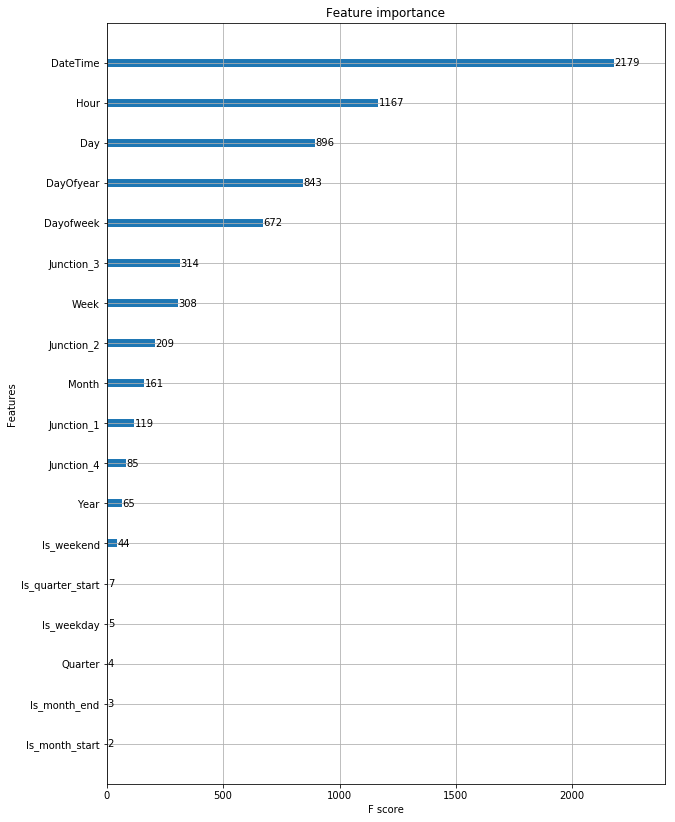

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plot_features(model, (10,14))

In [23]:
model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=220,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [24]:
pred=model.predict(test)
sub['Vehicles']=np.expm1(pred)
sub.to_csv('xgb_final.csv',index=False)

##### https://github.com/AnilBetta/AV_JantaHack-IOT-Timeseries-/blob/master/XGBOOST.ipynb